## Trabalho Prático de Introdução ao Processamento Digital de Imagens

In [297]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

### Correlação

In [336]:
def load_filter(filter_path):
    with open(filter_path, 'r') as file:
        line = file.readline()
        values = [float(x) for x in line.split()]
    
    m =  int(values[0])
    n = int(values[1])
    stride = int(values[2])

    filter = []
    for i in range(0, m):
        row = []
        for j in range(0, n):    
            row.append(values[3:][i*n + j])
        filter.append(row)
    
    return stride, np.array(filter)

def apply_correlation(matrix, filter, stride=1):
    if(stride > 1):
        return convolve2d(matrix, filter, mode='valid')[::stride, ::stride].astype(int)
    else:
        return convolve2d(matrix, filter, mode='valid').astype(int)
    
def apply_transform_box(image_channels, stride, filter):
    # Record the start time
    start_time = time.time()

    R, G, B = image_channels
    
    R_box = apply_correlation(R, filter, stride)
    G_box = apply_correlation(G, filter, stride)
    B_box = apply_correlation(B, filter, stride)

    img_merged_box = cv2.merge((R_box, G_box, B_box))

    # Record the end time
    end_time = time.time()
    
    return img_merged_box, end_time - start_time

def histogram_expansion(matrix):
    r_max = matrix.max()
    r_min = matrix.min()
    l = 255

    expansion = lambda r : round((r - r_min) * (l - 1) / (r_max - r_min))

    return np.vectorize(expansion)(matrix)


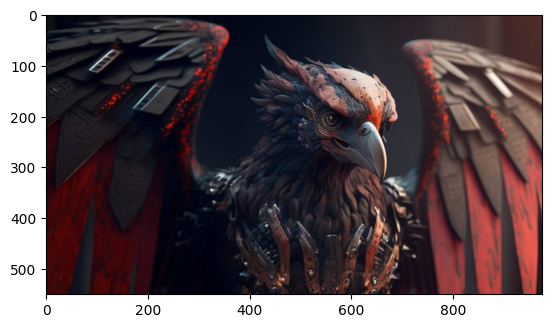

In [262]:
img = cv2.cvtColor(cv2.imread("mascote-flamengo.jpg"), cv2.COLOR_BGR2RGB)
# show image
plt.imshow(img)

In [265]:
img.shape

(550, 976, 3)

#### Filtro box 15x15

Execution time: 419.918ms


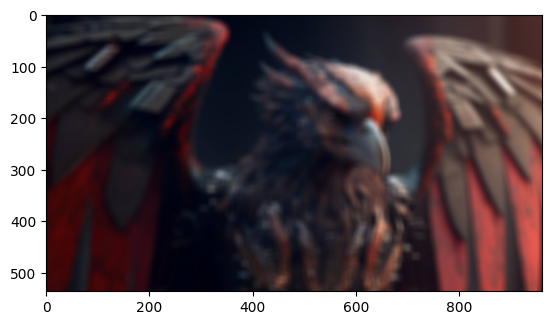

In [308]:
stride_15x15, filter_box_15x15 = load_filter("filtro_box_15x15.txt")
img_merged_box_15x15, exec_time_box_15x15 = apply_transform_box(cv2.split(img), stride_15x15, filter_box_15x15)
plt.imshow(img_merged_box_15x15)
print(f"Execution time: {round(exec_time_box_15x15*1000, 3)}ms")

In [311]:
img_merged_box_15x15.shape

(536, 962, 3)

#### Box filter 1x15 followed by box filter 15x1

Execution time: 110.749ms


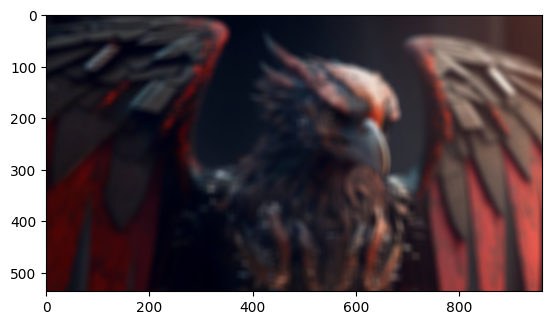

In [315]:
stride_1x15, filter_box_1x15 = load_filter("filtro_box_1x15.txt")
img_merged_box_1x15, exec_time_box_1x15 = apply_transform_box(cv2.split(img), stride_1x15, filter_box_1x15)

stride_15x1, filter_box_15x1 = load_filter("filtro_box_15x1.txt")
img_merged_box_15x1, exec_time_box_15x1 = apply_transform_box(cv2.split(img_merged_box_1x15), stride_15x1, filter_box_15x1)

print(f"Execution time: {round((exec_time_box_1x15 + exec_time_box_15x1)*1000, 3)}ms")
plt.imshow(img_merged_box_15x1)

In [310]:
img_merged_box_15x1.shape

(536, 962, 3)

### Filtro de Sobel

In [408]:
img = cv2.cvtColor(cv2.imread("lena.jpg"), cv2.COLOR_BGR2RGB)

In [428]:
R, G, B = cv2.split(img)

stride_horizontal, filtro_sobel_horizontal = load_filter("filtro_sobel_horizontal.txt")

R_sobel_horizontal = np.abs(apply_correlation(R, filtro_sobel_horizontal, stride_horizontal))
G_sobel_horizontal = np.abs(apply_correlation(G, filtro_sobel_horizontal, stride_horizontal))
B_sobel_horizontal = np.abs(apply_correlation(B, filtro_sobel_horizontal, stride_horizontal))

stride_vertical, filtro_sobel_vertical = load_filter("filtro_sobel_vertical.txt")

R_sobel_vertical = np.abs(apply_correlation(R, filtro_sobel_vertical, stride_vertical))
G_sobel_vertical = np.abs(apply_correlation(G, filtro_sobel_vertical, stride_vertical))
B_sobel_vertical = np.abs(apply_correlation(B, filtro_sobel_vertical, stride_vertical))


In [429]:
R_sobel = histogram_expansion(R_sobel_horizontal + R_sobel_vertical)
G_sobel = histogram_expansion(G_sobel_horizontal + G_sobel_vertical)
B_sobel = histogram_expansion(B_sobel_horizontal + B_sobel_vertical)



#### Sobel applied over R channel

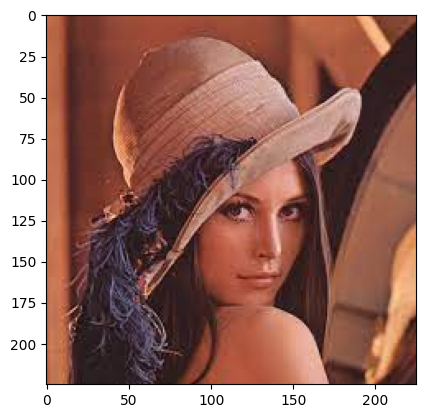

In [430]:
plt.imshow(img)

In [436]:
R_sobel

array([[ 6,  9,  7, ...,  2,  9,  6],
       [ 6,  9,  7, ...,  4,  7,  4],
       [ 7, 10,  8, ...,  6,  2, 14],
       ...,
       [15, 10,  2, ..., 22,  9,  5],
       [15, 10,  1, ..., 15,  7,  3],
       [18, 11,  2, ...,  5,  7,  3]])

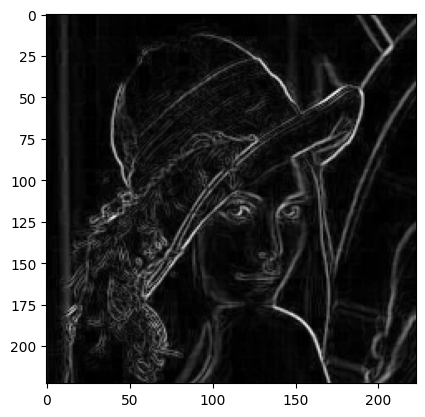

In [431]:
plt.imshow(R_sobel, cmap='gray', vmin=0, vmax=255)

In [434]:
G_sobel

array([[ 1,  3,  2, ...,  4, 14,  6],
       [ 2,  2,  2, ...,  4, 14, 10],
       [ 3,  3,  3, ...,  6,  7,  7],
       ...,
       [23, 20,  7, ..., 19,  7,  2],
       [23, 20,  7, ..., 13,  7,  5],
       [26, 23, 10, ...,  3,  8,  4]])

#### Sobel applied over G channel

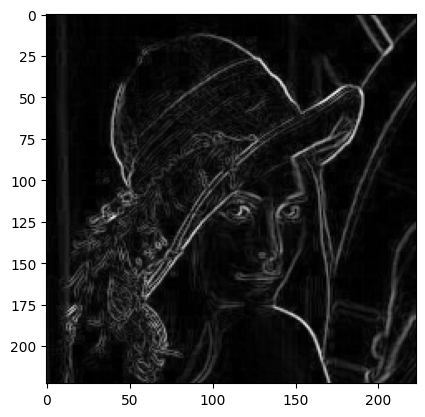

In [432]:
plt.imshow(G_sobel, cmap='gray', vmin=0, vmax=255)

In [435]:
B_sobel

array([[ 5,  8,  6, ...,  2, 12,  7],
       [ 5,  8,  7, ...,  5, 12, 12],
       [ 5,  9,  7, ...,  9,  7,  5],
       ...,
       [26, 22,  9, ..., 20,  6,  3],
       [27, 24, 10, ..., 11,  7,  6],
       [27, 24, 10, ...,  2, 11,  4]])

#### Sobel applied over B channel

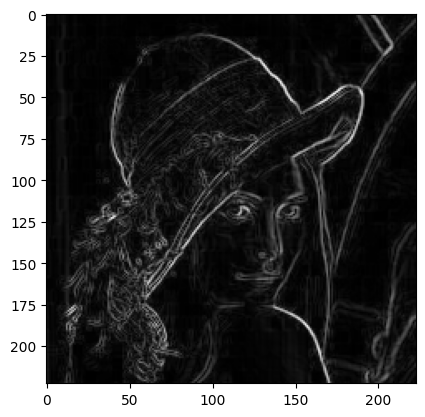

In [433]:
plt.imshow(B_sobel, cmap='gray', vmin=0, vmax=255)